## Dependency
The following library is needed to execute this .ipynb file.
- Jupyter Notebook
- Py4J
- Matplotlib, Seaborn, Numpy

After install those library, start Jupyter Notebook server:
```
$ jupyter notebook
```
Then access to localhost:8888 from web browser and open this .ipynb file.

## Packaging
Before using gisutil, building and packaging of gisutil is needed.

In [1]:
!sbt assembly > /dev/null

In [2]:
ls target/**/*.jar

target/scala-2.11/gisutil-assembly-1.0.jar


## Start Py4J GatewayServer
Py4J GatewayServer process is needed to use gisutil from Python program.
The following is sample code of starting Py4J GatewayServer subprocess.

In [3]:
# finds JAR of py4j
import os
base_dir = os.getenv('VIRTUAL_ENV') or '/usr/local'
for root, dirs, files in os.walk(base_dir + '/share/py4j'):
    for file in files:
        if file.startswith('py4j') and file.endswith('.jar'):
            py4j_path = os.path.join(root, file)

In [4]:
import subprocess
classpath = py4j_path + ':target/scala-2.11/gisutil-assembly-1.0.jar'
port = '25333'
cmd = 'java -cp ' + classpath + ' py4j.GatewayServer ' + port
sp = subprocess.Popen(cmd, shell=True)

## Sample execution from Python

### Preparation
The following is sample code of preparation in Jupyter Notebook process.

In [5]:
# Initializes Java gateway to use Java code from Python program.
from py4j.java_gateway import JavaGateway
gateway = JavaGateway()

In [6]:
# initialize handler of spatial query
config = gateway.jvm.signdoubt.gisutil.EasyConfig(
    gateway.jvm.scala.collection.immutable.Map.Map1('subspace.point.count.max', '10'))
query_handler = gateway.jvm.signdoubt.gisutil.core.SpatialQueryHandlerFactory.subSpaceAwareQueryHandlerInMemory(config)

In [7]:
# define utilities
def point(x, y):
    return gateway.jvm.signdoubt.gisutil.RoundedPoint(r(x), r(y))

def rectangle(low_x, low_y, up_x, up_y):
    return gateway.jvm.signdoubt.gisutil.Rectangle(r(low_x), r(low_y), r(up_x), r(up_y))

def r(v):
    return int(v * 10000000)

def restore(rounded_point):
    return (float(rounded_point.x()) / 10000000, float(rounded_point.y()) / 10000000)

In [8]:
import numpy as np

# define sample data
np.random.seed(0)
xs = [135 + i for i in np.random.randn(1000)]
ys = [35 + i for i in np.random.randn(1000)]

# put data
for x, y in zip(xs, ys):
    query_handler.put(point(x, y), str.format('p#{0},{1}', x, y))

In [9]:
# matplotlib for plotting point
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### Range scan
The following is range scan query. Total amount of points for each block are displayed.

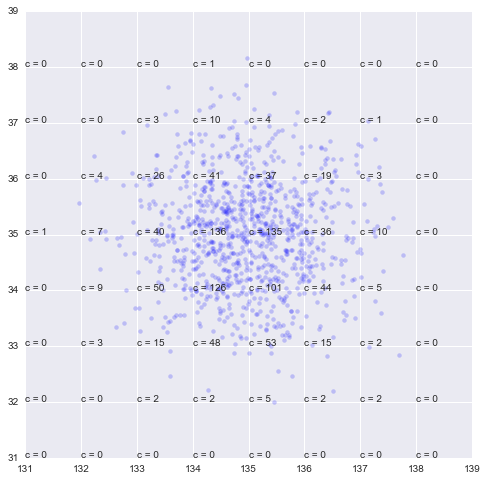

In [10]:
import itertools

plt.figure(figsize=(8, 8))
plt.scatter(xs, ys, alpha=0.2, linewidths=0)

for x, y in itertools.product(range(131, 139), range(31, 39)):
    count = query_handler.scan(rectangle(x, y, x + 1, y + 1)).size()
    plt.text(x, y, 'c = ' + str(count))

### Nearest Neighbor scan
Sample code of nearest neighbors scan is as below. The red points are the k-nearests from point x.

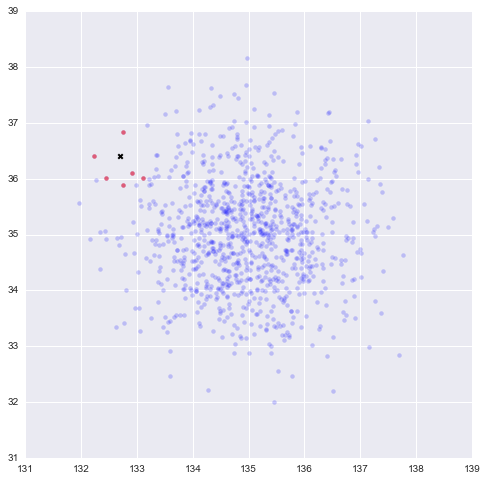

In [11]:
k = 6
base = (132.7, 36.4)

# plot base point and other points
plt.figure(figsize=(8, 8))
plt.scatter(base[0], base[1], c='black', marker='x', linewidths=2)
plt.scatter(xs, ys, alpha=0.2, linewidths=0)

# search k-nearest neighbors
itr = query_handler.nearestNeighbor(point(base[0], base[1]), k).iterator()
knn = []
while (itr.hasNext()):
    knn.append(restore(itr.next()._1()))

# plot k-nearest neighbors
knn_x, knn_y = zip(*knn)
plt.scatter(knn_x, knn_y, c='red', alpha=0.5, linewidths=0)

## Termination
Termination of Java gateway server subprocess.

In [12]:
sp.terminate()